<a href="https://colab.research.google.com/github/seba6029/LMHAI/blob/main/Week3_GraphNeuralNetworks/Sebastian-GCN_Week3_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build and train a graph convolutional neural network using PyTorch Geometric for the **node property prediction** task.

We will use ogbn-products dataset.

## OGBN-Products

The ogbn-products dataset is an undirected and unweighted graph, representing an Amazon product co-purchasing network. Nodes represent products sold in Amazon, and edges between two products indicate that the products are purchased together. Node features are generated by extracting bag-of-words features from the product descriptions followed by a Principal Component Analysis to reduce the dimension to 100.

**The task is to predict the category of a product in a multi-class classification setup, where the 47 top-level categories are used for target labels.**

In [1]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.0.1+cu118


In [2]:
# i'll try using weights and biases for this one
!pip install wandb -qU
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Download the necessary packages for PyG. Make sure that your version of torch matches the output from the cell above. In case of any issues, more information can be found on the [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [3]:
# Install torch geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{torch.__version__}.html
!pip install torch-geometric
!pip install ogb

Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 60.7 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910460 sha256=409c5d51fda3b93b4d09489680114a6679833666e1de0bc1be5505e8fd22abaf
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=

In [4]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
import numpy as np
from torch_geometric.typing import SparseTensor

## Load and Preprocess the Dataset

In [5]:
dataset_name = 'ogbn-products'
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor())
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))


This will download 1.38GB. Will you proceed? (y/N)
y


Downloaded 1.38 GB: 100%|██████████| 1414/1414 [00:27<00:00, 51.18it/s]


Extracting dataset/products.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 102.07it/s]


Saving...


Done!


Device: cuda


In [6]:
data

Data(num_nodes=2449029, x=[2449029, 100], y=[2449029, 1], adj_t=[2449029, 2449029, nnz=123718280])

This dataset is very big and if you try to run it as it is on colab, you may get an out of memory error.

One solution is to use batching and train on subgraphs. Here, we will just make a smaller dataset so that we can train it in one go.

In [7]:
# We need to have edge indxes to make a subgraph. We can get those from the adjacency matrix.
data.edge_index = torch.stack([data.adj_t.__dict__["storage"]._row, data.adj_t.__dict__["storage"]._col])

# We will only use the first 100000 nodes.
# memory issues so only 80000
sub_nodes = 80000
sub_graph = data.subgraph(torch.arange(sub_nodes))

# Update the adjaceny matrix according to the new graph
sub_graph.adj_t = SparseTensor(
    row=sub_graph.edge_index[0],
    col=sub_graph.edge_index[1],
    sparse_sizes=None,
    is_sorted=True,
    trust_data=True,
)

sub_graph = sub_graph.to(device)

sub_graph

Data(num_nodes=80000, x=[80000, 100], y=[80000, 1], adj_t=[80000, 80000, nnz=1805480], edge_index=[2, 1805480])

In [8]:
# Spilt data into train, validation and test set
split_sizes = [int(sub_nodes*0.8),int(sub_nodes*0.05),int(sub_nodes*0.15)]
indices = torch.arange(sub_nodes)
np.random.shuffle(indices.numpy())
split_idx = {s:t for t,s in zip(torch.split(indices, split_sizes, dim=0), ["train", "valid", "test"])}
split_idx

{'train': tensor([39997, 23195, 24371,  ..., 37153, 14086, 40647]),
 'valid': tensor([51307, 50591, 19999,  ..., 68370,  7318, 13826]),
 'test': tensor([12588,  5750, 68308,  ..., 61025, 43541, 31191])}

In [17]:
print(f"Feature Length of each node: {sub_graph.x.shape[1]}")

Feature Length of each node: 100


In [9]:
# To free up memory
data = None

## GCN Model

Now we will implement our Graph Convolutional Networks (GCN) model! Specifically, we will use GCN as the foundation a graph neural network (Kipf et al. (2017)). To do so, we will work with PyG's built-in GCNConv layer.

In highlevel, the GCN model works in the following way:

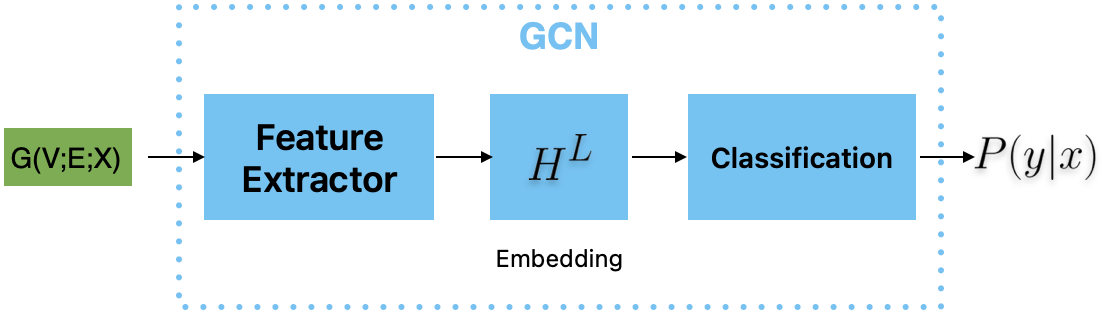

And in practice our forward layer configuration is done by the following scheme:
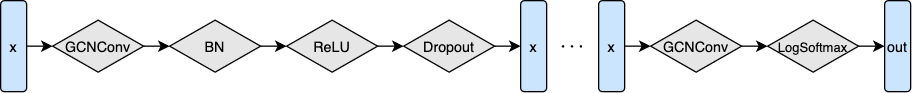

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = [
            GCNConv(input_dim, hidden_dim),
        ]

        for _ in range(num_layers-1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.last_layer = GCNConv(hidden_dim, output_dim)


        # A list of 1D batch normalization layers
        self.bns = []
        for _ in range(num_layers):
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        self.convs = torch.nn.ModuleList(self.convs)
        self.bns = torch.nn.ModuleList(self.bns)

        # The log softmax layer
        self.softmax = torch.nn.LogSoftmax()


        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):

        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.last_layer(x, adj_t)

        if not self.return_embeds:
          x = self.softmax(x)

        return x


In [10]:
def train(model, data, train_idx, optimizer, loss_fn):
    model.train()
    loss = 0

    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.adj_t)  # Perform a single forward pass.
    loss = loss_fn(out[train_idx], data.y[train_idx].reshape(-1))

    loss.backward()
    optimizer.step()

    return loss.item()

In [11]:
# Test function here
@torch.no_grad()
def test(model, data, split_idx, evaluator, save_model_results=False):
    model.eval()

    # The output of model on all data
    out = model(data.x, data.adj_t)

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_model_results:
      print ("Saving Model Predictions")

      data = {}
      data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

      df = pd.DataFrame(data=data)
      # Save locally as csv
      df.to_csv('ogbn-products_node.csv', sep=',', index=False)


    return train_acc, valid_acc, test_acc

In [12]:
args1 = {
    'device': device,
    'num_layers': 1,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 200,
}
args3 = {
    'device': device, 'num_layers': 3, 'hidden_dim': 256,
    'dropout': 0.5,'lr': 0.01, 'epochs': 200,
}
args5 = {
    'device': device, 'num_layers': 5, 'hidden_dim': 256,
    'dropout': 0.5,'lr': 0.01, 'epochs': 200,
}

We instantize three different instances of our GCN model where we vary the mnumber of convolutional layers, $L=\{1,2,3\}$ to analyse if it has an effect on the predictive ability.

In [13]:
modelL1 = GCN(sub_graph.num_features, args1['hidden_dim'],
            dataset.num_classes, args1['num_layers'],
            args1['dropout']).to(device)
modelL3 = GCN(sub_graph.num_features, args3['hidden_dim'],
            dataset.num_classes, args3['num_layers'],
            args3['dropout']).to(device)
modelL5 = GCN(sub_graph.num_features, args5['hidden_dim'],
            dataset.num_classes, args5['num_layers'],
            args5['dropout']).to(device)
evaluator = Evaluator(name='ogbn-products')
print('Model (L=3)-GCN layers specification')
print('====================================')
modelL3

Model (L=3)-GCN layers specification


GCN(
  (last_layer): GCNConv(256, 47)
  (convs): ModuleList(
    (0): GCNConv(100, 256)
    (1-2): 2 x GCNConv(256, 256)
  )
  (bns): ModuleList(
    (0-2): 3 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (softmax): LogSoftmax(dim=None)
)

## Training and testing

In [14]:
import copy

train_idx = split_idx['train'].to(device)

# reset the parameters to initial random value
modelL1.reset_parameters()
modelL3.reset_parameters()
modelL5.reset_parameters()

optimizer1 = torch.optim.Adam(modelL1.parameters(), lr=args1['lr'])
optimizer3 = torch.optim.Adam(modelL3.parameters(), lr=args3['lr'])
optimizer5 = torch.optim.Adam(modelL5.parameters(), lr=args5['lr'])
loss_fn = F.nll_loss

best_model1,best_model3,best_model5 = None, None, None
best_valid_acc1, best_valid_acc3, best_valid_acc5 = 0, 0, 0

loss_ls1, loss_ls3, loss_ls5 = [], [], []
train_acc_ls1, train_acc_ls3, train_acc_ls5 = [], [], []
valid_acc_ls1, valid_acc_ls3, valid_acc_ls5 = [], [], []
test_acc_ls1, test_acc_ls3, test_acc_ls5 = [], [], []

wandb.init(
      # Set the project where this run will be logged
      project="basic-intro",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"GCN_3",
      # Track hyperparameters and run metadata
      config={
      "learning_rate": args3["lr"],
      "architecture": "GCN-L3",
      "dataset": "ogbn-products",
      "epochs": args3["epochs"],
      })

for epoch in range(1, 1 + args1["epochs"]):
  loss1 = train(modelL1, sub_graph, train_idx, optimizer1, loss_fn)
  result1 = test(modelL1, sub_graph, split_idx, evaluator)
  train_acc1, valid_acc1, test_acc1 = result1
  loss3 = train(modelL3, sub_graph, train_idx, optimizer3, loss_fn)
  result3 = test(modelL3, sub_graph, split_idx, evaluator)
  train_acc3, valid_acc3, test_acc3 = result3
  loss5 = train(modelL1, sub_graph, train_idx, optimizer5, loss_fn)
  result5 = test(modelL1, sub_graph, split_idx, evaluator)
  train_acc5, valid_acc5, test_acc5 = result5

  loss_ls1.append(loss1)
  train_acc_ls1.append(train_acc1)
  valid_acc_ls1.append(valid_acc1)
  test_acc_ls1.append(test_acc1)
  loss_ls3.append(loss3)
  train_acc_ls3.append(train_acc3)
  valid_acc_ls3.append(valid_acc3)
  test_acc_ls3.append(test_acc3)
  loss_ls5.append(loss5)
  train_acc_ls5.append(train_acc5)
  valid_acc_ls5.append(valid_acc5)
  test_acc_ls5.append(test_acc5)

  # just adding L=3 since there is no major difference, found a posteriori
  wandb.log({"train_acc": train_acc3,
             "valid_acc": valid_acc3,
             "test_acc": test_acc3,
             "loss": loss3})

  if valid_acc1 > best_valid_acc1:
      best_valid_acc1 = valid_acc1
      best_model1 = copy.deepcopy(modelL1)
  if valid_acc3 > best_valid_acc3:
    best_valid_acc3 = valid_acc3
    best_model3 = copy.deepcopy(modelL3)
  if valid_acc5 > best_valid_acc5:
    best_valid_acc5 = valid_acc5
    best_model5 = copy.deepcopy(modelL5)
  print(f'Epoch: {epoch:02d}, '
        f'Loss: {loss1:.4f}, {loss3:.4f}, {loss5:.4f} '
        f'Train: {100 * train_acc1:.2f}%, {100 * train_acc3:.2f}%, {100 * train_acc5:.2f}% '
        f'Valid: {100 * valid_acc1:.2f}%, {100 * valid_acc3:.2f}%, {100 * valid_acc5:.2f}% '
        f'Test: {100 * test_acc1:.2f}%, {100 * test_acc3:.2f}%, {100 * test_acc5:.2f}%')

print('Complete')
wandb.finish()

wandb: Currently logged in as: sebastianhansen98. Use `wandb login --relogin` to force relogin


<ipython-input-9-bd2bcc944472>:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Epoch: 01, Loss: 4.3535, 4.0806, 2.5603 Train: 57.14%, 50.75%, 57.03% Valid: 55.20%, 49.50%, 55.12% Test: 57.56%, 50.12%, 57.40%
Epoch: 02, Loss: 2.5593, 1.8926, 1.6584 Train: 72.42%, 67.66%, 72.51% Valid: 71.05%, 67.80%, 71.30% Test: 72.48%, 67.38%, 72.59%
Epoch: 03, Loss: 1.6626, 1.1975, 1.2679 Train: 75.82%, 76.10%, 75.89% Valid: 74.83%, 75.58%, 74.95% Test: 75.82%, 75.81%, 75.87%
Epoch: 04, Loss: 1.2701, 0.9594, 1.0760 Train: 77.56%, 80.26%, 77.61% Valid: 76.85%, 79.45%, 76.90% Test: 77.58%, 80.35%, 77.62%
Epoch: 05, Loss: 1.0767, 0.8532, 0.9622 Train: 79.18%, 81.78%, 79.23% Valid: 78.45%, 80.73%, 78.53% Test: 79.22%, 81.94%, 79.23%
Epoch: 06, Loss: 0.9623, 0.7855, 0.8912 Train: 80.34%, 82.39%, 80.37% Valid: 79.47%, 81.60%, 79.53% Test: 80.33%, 82.23%, 80.34%
Epoch: 07, Loss: 0.8914, 0.7495, 0.8405 Train: 81.42%, 83.13%, 81.45% Valid: 80.47%, 82.53%, 80.53% Test: 81.47%, 82.83%, 81.57%
Epoch: 08, Loss: 0.8457, 0.7044, 0.8106 Train: 82.16%, 84.00%, 82.18% Valid: 80.97%, 83.53%, 81.0

loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁▆▇▇▇▇▇▇▇▇██████████████████████████████
train_acc,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████████
valid_acc,▁▅▇▇▇▇▇▇▇▇██████████████████████████████
loss,0.29086
test_acc,0.9005
train_acc,0.92269
valid_acc,0.899


We have now trained our three different instances of GCN. Below we visualize and compare training loss and predictability between the methods.

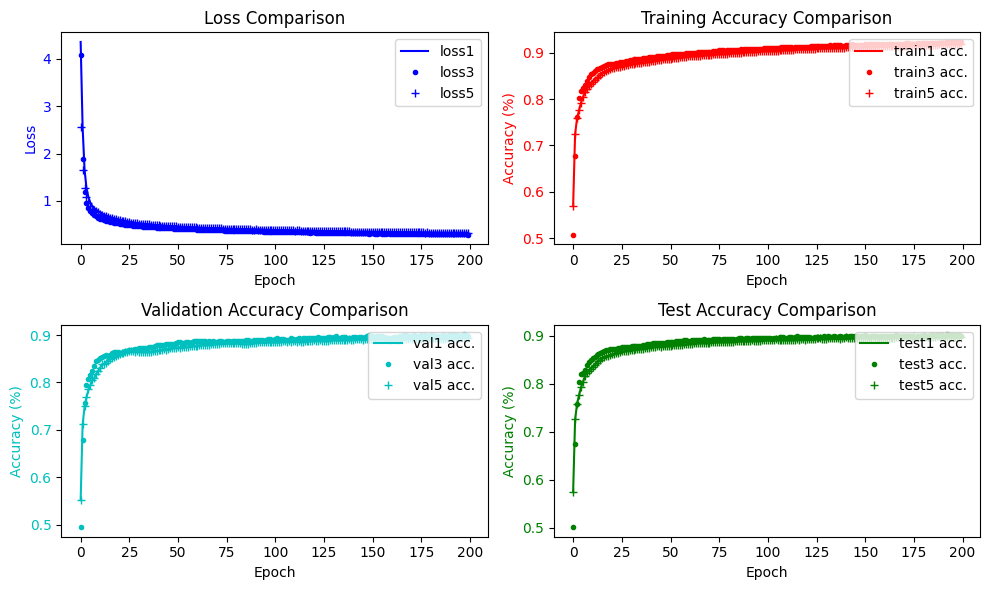

In [15]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Plotting the loss on the left axis (subplot 1)
axes[0, 0].set_title('Loss Comparison')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].plot(loss_ls1, 'b-', label='loss1')
axes[0, 0].plot(loss_ls3, 'b.', label='loss3')
axes[0, 0].plot(loss_ls5, 'b+', label='loss5')
axes[0, 0].set_ylabel('Loss', color='b')
axes[0, 0].tick_params(axis='y', labelcolor='b')
axes[0, 0].legend(loc='upper right')

# Plotting the training accuracy on the right axis (subplot 2)
axes[0, 1].set_title('Training Accuracy Comparison')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].plot(train_acc_ls1, 'r-', label='train1 acc.')
axes[0, 1].plot(train_acc_ls3, 'r.', label='train3 acc.')
axes[0, 1].plot(train_acc_ls5, 'r+', label='train5 acc.')
axes[0, 1].set_ylabel('Accuracy (%)', color='r')
axes[0, 1].tick_params(axis='y', labelcolor='r')
axes[0, 1].legend(loc='upper right')

# Plotting the validation accuracy on the left axis (subplot 3)
axes[1, 0].set_title('Validation Accuracy Comparison')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].plot(valid_acc_ls1, 'c-', label='val1 acc.')
axes[1, 0].plot(valid_acc_ls3, 'c.', label='val3 acc.')
axes[1, 0].plot(valid_acc_ls5, 'c+', label='val5 acc.')
axes[1, 0].set_ylabel('Accuracy (%)', color='c')
axes[1, 0].tick_params(axis='y', labelcolor='c')
axes[1, 0].legend(loc='upper right')

# Plotting the test accuracy on the right axis (subplot 4)
axes[1, 1].set_title('Test Accuracy Comparison')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].plot(test_acc_ls1, 'g-', label='test1 acc.')
axes[1, 1].plot(test_acc_ls3, 'g.', label='test3 acc.')
axes[1, 1].plot(test_acc_ls5, 'g+', label='test5 acc.')
axes[1, 1].set_ylabel('Accuracy (%)', color='g')
axes[1, 1].tick_params(axis='y', labelcolor='g')
axes[1, 1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


Since all methods seems to perform equally well in above figure, we consider the (L=3)-GCN specification going forward and report the best model with the best validation accuracy evaluated while training above:

In [16]:
best_result3 = test(best_model3, sub_graph, split_idx, evaluator, save_model_results=True)
train_acc3, valid_acc3, test_acc3 = best_result3
print(f'Best model(L3): '
      f'Train: {100 * train_acc3:.2f}%, '
      f'Valid: {100 * valid_acc3:.2f}% '
      f'Test: {100 * test_acc3:.2f}%')

Saving Model Predictions
Best model(L3): Train: 92.32%, Valid: 90.12% Test: 90.17%


<ipython-input-9-bd2bcc944472>:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


###Model summary

| Accuracy| Train | Validation | Test |
| -       | -     |-           |-     |
| GCN (L3)     | 92%   |90%         |90%   |

The test score of 90\% accurary is somewhat surprising compared to existing publications for node prediction methods on this graph data set `ogbn-products`. The simple method of full batch GCN is usually reported around 75\% test accuracy while state of the art implementations achieves around 90\% accuracy. The site [Papers with Code](https://paperswithcode.com/sota/node-property-prediction-on-ogbn-products) offers a well-structured overview and comparison of models.

The primary reason for scoring a suprisingly high test score might be the fact that we are using only a *subset* of the whole graph dataset. This complicates a comparison and all else equal should be easier for the model to learn the graph structures.

The results of the run is also stored in weight and biases and can be accessed via [wandb project](https://wandb.ai/sebastianhansen98/basic-intro) (I hope so!)

# Comparison with GAT

## GAT module

We will now implement attention mechanisms to perform node classification in the form of Grapk Attention Networks (GATs) cf. Veličković et al. (2018).

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function. In this implementation we will leverage
 [pytorch geometrics](https://pytorch-geometric.readthedocs.io/en/latest/modules/graphgym.html?highlight=GATconv#torch_geometric.graphgym.models.GATConv) (`GATConv`) implementation of the graph attention layer.

In [28]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):

        super(GAT, self).__init__()

        # A list of GCNConv layers
        self.convs = [
            GATConv(input_dim, hidden_dim),
        ]

        for _ in range(num_layers-1):
            self.convs.append(GATConv(hidden_dim, hidden_dim))

        self.last_layer = GATConv(hidden_dim, output_dim)


        # A list of 1D batch normalization layers
        self.bns = []
        for _ in range(num_layers):
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        self.convs = torch.nn.ModuleList(self.convs)
        self.bns = torch.nn.ModuleList(self.bns)

        # The log softmax layer
        self.softmax = torch.nn.LogSoftmax()


        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):

        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.last_layer(x, adj_t)

        if not self.return_embeds:
          x = self.softmax(x)

        return x


In [29]:
args = {
    'device': device, 'num_layers': 3, 'hidden_dim': 256,
    'dropout': 0.5,'lr': 0.01, 'epochs': 200,
}
modelGAT = GAT(sub_graph.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
evaluator = Evaluator(name='ogbn-products')

In [32]:
modelGAT.reset_parameters()
optimizer = torch.optim.Adam(modelGAT.parameters(), lr=args['lr'])
#save to wandb
wandb.init(
      # Set the project where this run will be logged
      project="basic-intro",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"GAT",
      # Track hyperparameters and run metadata
      config={
      "learning_rate": args["lr"],
      "architecture": "GAT",
      "dataset": "ogbn-products",
      "epochs": args["epochs"],
      })

In [ ]:
#free up memory

del modelL1, modelL5, best_model1, best_model5

torch.cuda.empty_cache()

In [36]:
import copy
train_idx = split_idx['train'].to(device)

# reset the parameters to initial random value
modelGAT.reset_parameters()
optimizer = torch.optim.Adam(modelGAT.parameters(), lr=args['lr'])

loss_fn = F.nll_loss

best_model = None
best_valid_acc = 0

loss_ls = []
train_acc_ls = []
valid_acc_ls = []
test_acc_ls = []

for epoch in range(1, 1 + args["epochs"]):

  loss = train(modelGAT, sub_graph, train_idx, optimizer, loss_fn)
  result = test(modelGAT, sub_graph, split_idx, evaluator)
  train_acc, valid_acc, test_acc = result

  loss_ls.append(loss)
  train_acc_ls.append(train_acc)
  valid_acc_ls.append(valid_acc)
  test_acc_ls.append(test_acc)

  # adding to wandb
  wandb.log({"train_acc": train_acc,
             "valid_acc": valid_acc,
             "test_acc": test_acc,
             "loss": loss})

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(modelGAT)

  print(f'Epoch: {epoch:02d}, '
        f'Loss:  {loss:.4f},  '
        f'Train: {100 * train_acc:.2f}%,  '
        f'Valid: {100 * valid_acc:.2f}%,  '
        f'Test:  {100 * test_acc:.2f}% ')

print('Complete')
# Mark the run as finished
wandb.finish()

<ipython-input-28-5d6f279b6248>:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Epoch: 01, Loss:  4.3540,  Train: 30.69%,  Valid: 30.12%,  Test:  30.70% 
Epoch: 02, Loss:  3.7919,  Train: 33.82%,  Valid: 33.48%,  Test:  33.67% 
Epoch: 03, Loss:  3.2773,  Train: 36.50%,  Valid: 35.60%,  Test:  36.20% 
Epoch: 04, Loss:  2.7038,  Train: 36.73%,  Valid: 35.62%,  Test:  36.58% 
Epoch: 05, Loss:  2.3355,  Train: 36.82%,  Valid: 35.68%,  Test:  36.42% 
Epoch: 06, Loss:  2.1709,  Train: 36.73%,  Valid: 35.65%,  Test:  36.25% 
Epoch: 07, Loss:  2.0564,  Train: 31.75%,  Valid: 30.20%,  Test:  31.01% 
Epoch: 08, Loss:  1.9138,  Train: 21.84%,  Valid: 20.42%,  Test:  21.07% 
Epoch: 09, Loss:  1.8947,  Train: 23.55%,  Valid: 22.65%,  Test:  22.92% 
Epoch: 10, Loss:  1.8797,  Train: 29.78%,  Valid: 28.62%,  Test:  29.37% 
Epoch: 11, Loss:  1.7886,  Train: 40.60%,  Valid: 39.83%,  Test:  40.54% 
Epoch: 12, Loss:  1.7062,  Train: 48.34%,  Valid: 48.12%,  Test:  48.24% 
Epoch: 13, Loss:  1.6322,  Train: 51.77%,  Valid: 51.45%,  Test:  51.87% 
Epoch: 14, Loss:  1.6156,  Train: 52.6

loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
test_acc,▁▁▃▄▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▆▇▇▇▇▇██████
train_acc,▁▁▃▄▅▅▅▅▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
valid_acc,▁▁▃▄▄▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
loss,0.63244
test_acc,0.82833
train_acc,0.8267
valid_acc,0.83775


### Summary

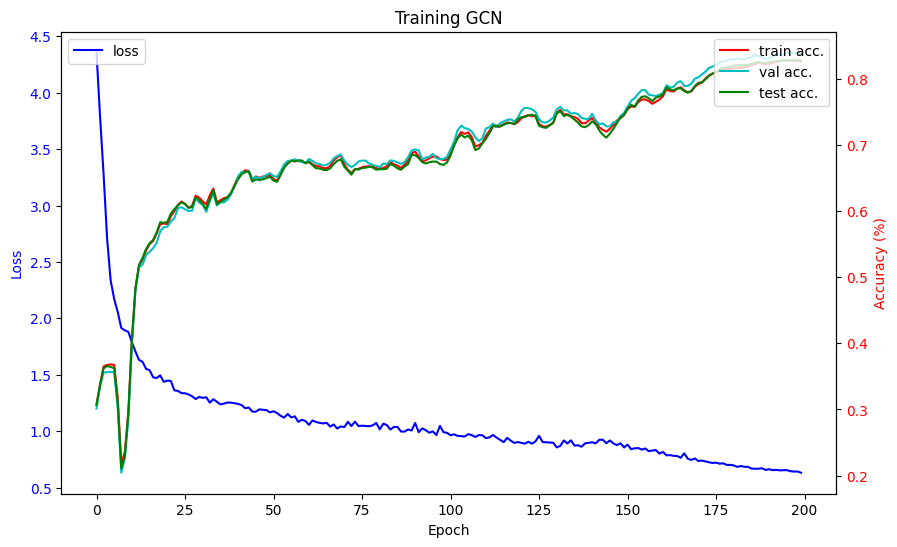

In [37]:
import matplotlib.pyplot as plt
# Plotting the loss on the left axis
plt.figure(figsize=(10, 6))
plt.title('Training GCN')
plt.xlabel('Epoch')
plt.plot(loss_ls, 'b-', label='loss')
plt.ylabel('Loss', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.legend(loc='upper left')

# Creating a secondary y-axis and plotting the other series on it
ax2 = plt.twinx()
ax2.plot(train_acc_ls, 'r-', label='train acc.')
ax2.plot(valid_acc_ls, 'c-', label='val acc.')
ax2.plot(test_acc_ls, 'g-', label='test acc.')
ax2.set_ylabel('Accuracy (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')
plt.show()

In [38]:
best_result = test(best_model, sub_graph, split_idx, evaluator, save_model_results=True)
train_acc, valid_acc, test_acc = best_result
print(f'Best model(GAT): '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Saving Model Predictions
Best model(GAT): Train: 82.83%, Valid: 83.97% Test: 82.84%


<ipython-input-28-5d6f279b6248>:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


| Accuracy| Train | Validation | Test |
| -       | -     |-           |-     |
| GCN      | 92%   |90%         |90%   |
| GAT     | 83%   |84%         |83%   |

In general the GAT method shows good classification performance of around 85\%. This is however a bit lower than GCN, but a full comparison and exploration of hyperparamters is out of scope for this assignment.

The results from the runs can be found on [wandb project](https://wandb.ai/sebastianhansen98/basic-intro) .